In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model (day2,activity5)
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found (day2,activity6)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table   (day2,activity6)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB  (day2,activity6)
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set. (day3,activity2)
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

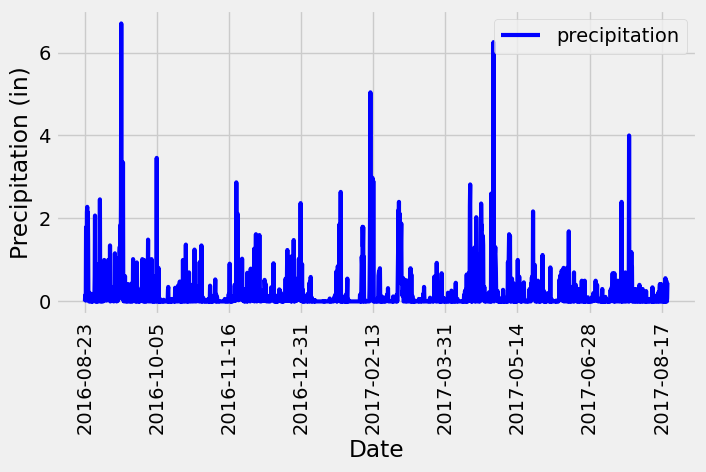

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.(day3,activity2) 
recentdate = session.query(func.max(Measurement.date)).first()[0]
# Calculate the date one year from the last date in data set. (day3,activity2)  (sources:https://strftime.org/, 
# & https://www.geeksforgeeks.org/python-strftime-function/)
recent_date = dt.datetime.strptime(recentdate,"%Y-%m-%d").date()
beginning_date = recent_date - dt.timedelta(days=365)
oneyearpast = beginning_date.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores  
prcp_data=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date>=oneyearpast).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcpresults=pd.DataFrame(prcp_data)
prcpresults=prcpresults.rename(columns={"prcp":"precipitation"})

# Sort the dataframe by date
prcpresults.sort_values(by=['date'], ascending=True)
prcpresults=prcpresults.dropna()
prcpresults=prcpresults.reset_index(drop=True)
prcpresults['date'].astype('str')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_plt=prcpresults.plot(color='b',figsize=(7,5),linewidth=3.0,grid=True, x='date',y='precipitation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel('Precipitation (in)')
plt.xlabel('Date')
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data (https://www.w3schools.com/python/pandas/ref_df_describe.asp)
prcpresults.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
totalstations = session.query(Station).distinct().count()
totalstations

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activestations_join = session.query(Measurement.station,func.count(Station.id)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activestations_join

[('USC00519281', 24948),
 ('USC00519397', 24516),
 ('USC00513117', 24381),
 ('USC00519523', 24021),
 ('USC00516128', 23508),
 ('USC00514830', 19818),
 ('USC00511918', 17811),
 ('USC00517948', 12348),
 ('USC00518838', 4599)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature. (Day3,Activity11; https://stackoverflow.com/questions/11830980/sqlalchemy-simple-example-of-sum-average-min-max)
stationdata=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station==activestations_join[0][0]).first()
stationdata

(54.0, 85.0, 71.66378066378067)

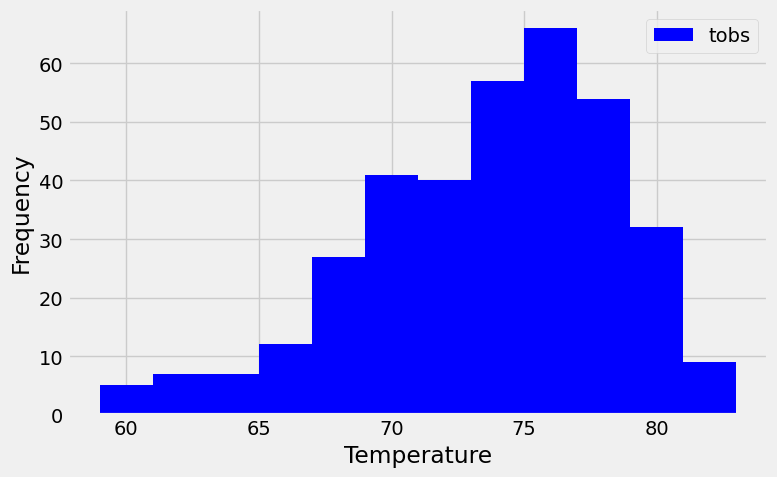

In [19]:
# Using the most active station id (used notes from class to filter data; Day 3, Activity 3)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data_observed=session.query(Measurement.date).order_by(Measurement.date.desc()).\
             filter(Measurement.station==activestations_join[0][0]).first()
begindate=list(np.ravel(data_observed))[0]
latestdate=dt.datetime.strptime(begindate,"%Y-%m-%d")
yeardata=latestdate-dt.timedelta(days=366)

temp_data=session.query(Measurement.tobs).\
             filter(Measurement.station==activestations_join[0][0]).\
             filter(Measurement.date>=yeardata).all()
temp_data=pd.DataFrame(temp_data)

hist = temp_data['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2, legend=True)
hist.set_ylabel("Frequency")
hist.set_xlabel("Temperature")
plt.tight_layout()
plt.show()

# Close Session

In [20]:
# Close Session
session.close()